# Introduction to Data Science
## Homework 4 

Student Name: Muhe Xie

Student Netid: mx419
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [1]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import math
def cleanBosonData(infile_name):
    data  = pd.read_csv(infile_name,sep = ',',index_col='EventId')
    data['Y'] = data['Label'].replace(['s','b'],[1,0]) #turn label into numeric
    data_no_label = data.drop('Label',1)
    for clm in data.columns: #create dummy variable
        if(data[clm] == -999).any():
            data_no_label[clm+'_mv'] = pd.get_dummies(data_no_label[clm])[-999.0]
    data_nan = data_no_label.replace(-999,np.nan) #deal with missing value
    data_replaced_mean = data_nan.replace(np.nan,data_nan.mean())
    scaled_part = preprocessing.scale(data_replaced_mean[data_replaced_mean.columns[0:9]]) #rescale the data
    scaled_part_df = pd.DataFrame(scaled_part,index = data_replaced_mean.index, columns=data_replaced_mean.columns[0:9]) #transform into dataframe  
    data_clean = pd.concat([scaled_part_df, data_replaced_mean[data_replaced_mean.columns[9:]]], axis=1) #concat the dataframe without rescale to the rescaled df
    return data_clean

### Part 2: Basic evaluations
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

In [2]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

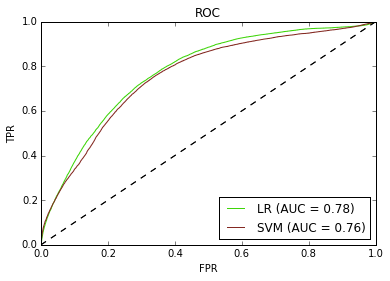

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
%matplotlib inline
# Code here
# the plot function is referenced from the Lecture_Metrics_Ranking.ipynb 
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
data_test_roc = data_test.drop('Y',1)
data_train_roc = data_train.drop('Y',1)

logreg = linear_model.LogisticRegression(C=1e30)
logreg.fit(data_train_roc, data_train['Y'])
my_svm = svm.SVC(kernel='linear',probability=True)
my_svm.fit(data_train_roc, data_train['Y'])
plotAUC(data_test['Y'], logreg.predict_proba(data_test_roc)[:,1], 'LR') 
plotAUC(data_test['Y'], my_svm.decision_function(data_test_roc), 'SVM')  

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

** Answer Here:**
 - Logistic Regression is better, for almost all the points of FPR, the TPR of logistic regression is always slightly better than SVM. And for the AUC value, Logistic Regression model is also slightly larger than SVM model. 

### Part 3: Model selection with cross-validation
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [4]:
# Code here
from sklearn.cross_validation import *
# function referenced from Lecture_Resampling.ipynb
def xValSVM(dataset, label_name, k, cs):
    #k folds cv
    cv = KFold(n=dataset.shape[0], n_folds = k)
    aucs = {}
    
    for train_index, test_index in cv: # loop for all the folds
        tr_f = dataset.iloc[train_index]
        va_f = dataset.iloc[test_index]
        for c in cs: #inner loop
            my_svm = svm.SVC(kernel='linear',C=c,probability=True)
            my_svm.fit(tr_f.drop(label_name,1),tr_f[label_name])
            met = roc_auc_score(va_f[label_name], my_svm.predict_proba(va_f.drop(label_name,1))[:,1])
            if (aucs.has_key(c)):
                aucs[c].append(met)
            else:
                aucs[c] = [met]
       
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 15 $C$ values in the interval `[10^(-9), ..., 10^1]` (i.e., do all powers of 10 from -9 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [5]:
#call the function
train = data_train
cs = [10**x for x in range(-9,2)]
aucs = xValSVM(train,'Y',10,cs)

#record the statistical values
xval_dict = {'xe':[], 'mean_value':[], 'std':[],'std_error':[]}
for i in range(-9,2):
    xval_dict['xe'].append(i)
    xval_dict['mean_value'].append(np.array(aucs[10**i]).mean())
    xval_dict['std'].append(np.sqrt(np.array(aucs[10**i]).var()))
    xval_dict['std_error'].append(np.sqrt(np.array(aucs[10**i]).var())/math.sqrt(10))
    
respd = pd.DataFrame(xval_dict)

#Get the intervals
respd['low'] = respd['mean_value'] - respd['std_error']
respd['up'] = respd['mean_value'] + respd['std_error']
# one standard error rule
best = respd['mean_value'].max()
best_1sde = best - respd['std_error'][(respd['mean_value']==best)]
e_1sde = respd['xe'][(respd['mean_value']>=best_1sde.values[0])].values.min()

max(meanAUC-StdErr(AUC)) = 0.739609


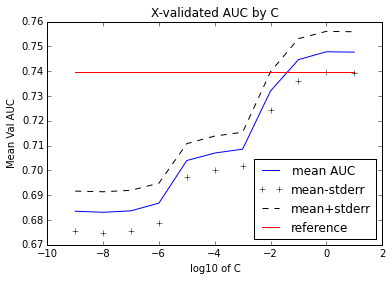

In [6]:
#draw the plots
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(respd['xe'], respd['mean_value'], label='mean AUC')
plt.plot(respd['xe'], respd['low'], 'k+',label = 'mean-stderr')
plt.plot(respd['xe'], respd['up'], 'k--',label = 'mean+stderr')
plt.plot(respd['xe'], np.repeat(respd['low'].max(),11), 'r',label = 'reference') #
plt.legend(loc=4)
ax.set_xlabel('log10 of C')
ax.set_ylabel('Mean Val AUC')
plt.title('X-validated AUC by C')
print "max(meanAUC-StdErr(AUC)) = %f" % respd['low'].max()

** Answer Here:**
- If we only consider the mean AUC value, the model with selected values does not beat out-of-the-box model since the AUC mean of out-of-the-box model is slightly larger than the model with selected parameter.
- The out-of-the-box model is more likely to cause overfitting. The model with the selected C value choosen by 1 standard error method is more conservative and simple, which is less likely to cause overfitting. In that case, the model with selected parameter values is better than out-of-the-box model

### Part 4: Learning Curve with Bootstrapping
In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.




1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.    
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples


In [7]:
# Bootstrapper funtion for svm and lr
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    aucs = []
    auc_res = []
    if lr == 1:
        for i in range(nruns):
            train_sample = train.iloc[np.random.randint(0,len(train),size=sampsize)]
            my_svm_boot = svm.SVC(kernel='linear',C=c,probability=True)
            my_svm_boot.fit(train_sample.drop('Y',1),train_sample['Y'])
            #auc_res.append(roc_auc_score(test['Y'],my_svm_boot.decision_function(test.drop('Y',1))))
            auc_res.append(roc_auc_score(test['Y'],my_svm_boot.predict_proba(test.drop('Y',1))[:,1]))
    elif lr ==0:
        for i in range(nruns):
            train_sample = train.iloc[np.random.randint(0,len(train),size=sampsize)]
            my_lr_boot = linear_model.LogisticRegression(C=c)
            
            my_lr_boot.fit(train_sample.drop('Y',1),train_sample['Y'])
            auc_res.append(roc_auc_score(test['Y'],my_lr_boot.predict_proba(test.drop('Y',1))[:,1]))
    
    aucs.append(np.array(auc_res).mean())
    aucs.append(np.sqrt(np.array(auc_res).var())/math.sqrt(len(auc_res)))  
    
    return aucs

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [8]:
#Code here
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
svm_means = []
svm_std = []
svm_mean_minus_std = []
svm_mean_add_std = []
#calculate svm result
for size in samplesizes:
    rsl_list_1 = modBootstrapper(data_train,data_test,20,size,1,10**e_1sde)
    svm_means.append(rsl_list_1[0])
    svm_std.append(rsl_list_1[1])
    svm_mean_minus_std.append(rsl_list_1[0]- rsl_list_1[1])
    svm_mean_add_std.append(rsl_list_1[0]+rsl_list_1[1])
#calculate lr result
lr_means = []
lr_std = []
lr_mean_minus_std = []
lr_mean_add_std = []
for size in samplesizes:
    rsl_list_2 = modBootstrapper(data_train,data_test,20,size,0,1e30)
    lr_means.append(rsl_list_2[0])
    lr_std.append(rsl_list_2[1])
    lr_mean_minus_std.append(rsl_list_2[0]- rsl_list_2[1])
    lr_mean_add_std.append(rsl_list_2[0]+rsl_list_2[1])


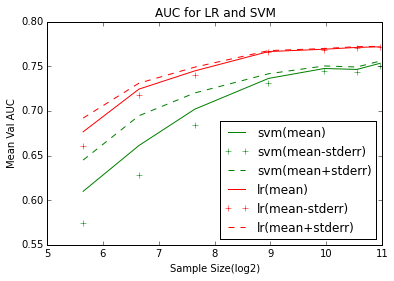

In [9]:
#plot the lines
X_axis_log = np.log2(np.array(samplesizes))
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
plt.plot(X_axis_log, np.array(svm_means),'g',label = 'svm(mean)')
plt.plot(X_axis_log,np.array(svm_mean_minus_std),'+g',label ='svm(mean-stderr)')
plt.plot(X_axis_log,np.array(svm_mean_add_std),'--g',label ='svm(mean+stderr)')

plt.plot(X_axis_log, np.array(lr_means),'r',label = 'lr(mean)')
plt.plot(X_axis_log,np.array(lr_mean_minus_std),'+r',label ='lr(mean-stderr)')
plt.plot(X_axis_log,np.array(lr_mean_add_std),'--r',label ='lr(mean+stderr)')

plt.legend(loc=4)
ax2.set_xlabel('Sample Size(log2)')
ax2.set_ylabel('Mean Val AUC')
plt.title('AUC for LR and SVM')


3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


** Answer Here:**
- Generally, when sample size is small, the logistic regression is better in AUC value and smaller  in StdError, it is more robust when dealing with small samples.(However, when I use svm.decision_function to calulate the Y score, in the range where sample size is very small like 50, svm sometimes is better than logistic regression in AUC mean, but consider the stderror and general conditions, logistic regression is the better choice )


- According to the plot, the data doubles, the values of log2(sample_size) increase by 1, we can see that when the sample size is more than 200, the AUC increases slightly when the data doubles. So it is not worthy to do that. However, when the initial sample is very small like 50, it might be worthy to double the data because the AUC increases significantly during that range. 

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



** Answer Here:**

According to ESL figure 7.8 and related content. The bias of cross-validation are stated as follows:

- If the learning curve has a significant slope at the given training set size range, according to the curve, the 1-Err changes rapidly during that range, it will lead to under-estimation of 1-Err when using n-folder cross-validation (because it only use part of the data set), thus it will overestimate the true prediction error. 


- The sample of cross-validation is always smaller than the dataset, which might cause the bias.